In [11]:
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

# Load the data

In [12]:
df = pd.Series()
df['raw'] = pd.read_csv('./Data/clean.csv',index_col='Time_Stamp',low_memory=False)
df['raw'].shape

(38709, 6)

In [13]:
df['raw'].head()

,Weekday,Area,Sub_Area,Free_Spots,Used_Spots,Full%
Time_Stamp,,,,,,
2014-04-08 08:00:00,Yes,12th Ave,12TH AVE BETWEEN E MARION ST AND E SPRING ST,12.0,0.0,0.0
2014-04-08 08:00:00,Yes,12th Ave,12TH AVE BETWEEN E COLUMBIA ST AND E MARION ST,13.0,7.0,35.0
2014-04-08 08:00:00,Yes,12th Ave,12TH AVE BETWEEN E SPRING ST AND E MADISON ST,15.0,4.0,21.0
2014-04-08 08:00:00,Yes,12th Ave,12TH AVE BETWEEN E JAMES CT AND E CHERRY ST,4.0,2.0,33.0
2014-04-08 08:00:00,Yes,12th Ave,12TH AVE BETWEEN E BARCLAY CT AND E JAMES CT,8.0,0.0,0.0


# Data selection

In this section, i will prepare the test and training data for the LSTM neural network.  
The goal of the model will be to predict how full a parking area is, based on previous data. I will investigate what sub area is the best candidate for this, and prepare a test and training set for the selected area.


In [4]:
df['raw']['Sub_Area'].value_counts().head()

NW 54TH SR ST BETWEEN 32ND AVE NW AND NW 54TH ST        77
NW 54TH SR ST BETWEEN 30TH WR AVE NW AND 32ND AVE NW    75
MAYNARD AVE S BETWEEN S JACKSON ST AND S KING ST        67
7TH AVE S BETWEEN S MAIN ST AND S JACKSON ST            67
MAYNARD AVE S BETWEEN S KING ST AND S WELLER ST         66
Name: Sub_Area, dtype: int64

NW 54TH SR ST BETWEEN 32ND AVE NW AND NW 54TH ST is the most frequent entry, and therefore this is choosen as the candidate.

In [5]:
df['data'] = df['raw'][df['raw']['Sub_Area'].isin({'NW 54TH SR ST BETWEEN 32ND AVE NW AND NW 54TH ST'})]

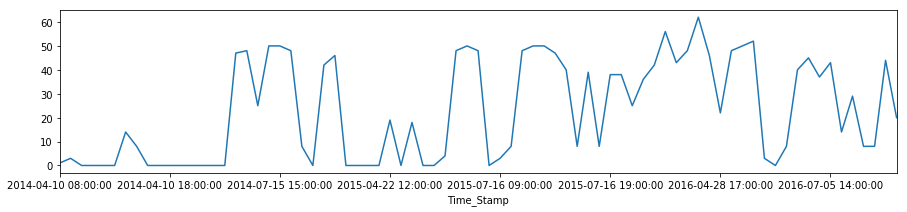

In [6]:
#Time series plot
plt.figure(figsize=(15,3));
df['data']['Full%'].plot();
plt.show();

In [7]:
mylist = df['data'].index.tolist()
date = []
for datetime in mylist:
    date.append(datetime.split(' ')[0])
    
print(set(date))

{'2016-04-28', '2015-04-22', '2015-07-16', '2016-07-05', '2014-04-10', '2014-07-15'}


The time series shows that the data spans over two years. By testing the unique dates in the dataset, it is revealed there are observations two times a year. First time is in April, and the second time is in June. I will choose one of these month, and predict the 2016 values based and train on the 2015 and 2014 values.

In [8]:
# Slice the dataset
data = pd.Series()
data['April14'] = df['data']['Full%'].loc['2014-04-10 08:00:00':'2014-04-10 20:00:00']
data['Jul14'] = df['data']['Full%'].loc['2014-07-15 08:00:00':'2014-07-15 20:00:00']
data['April15'] = df['data']['Full%'].loc['2015-04-22 08:00:00':'2015-04-22 20:00:00']
data['Jul15'] = df['data']['Full%'].loc['2015-07-16 08:00:00':'2015-07-16 20:00:00']
data['April16'] = df['data']['Full%'].loc['2016-04-28 08:00:00':'2016-04-28 20:00:00']
data['Jul16'] = df['data']['Full%'].loc['2016-07-05 08:00:00':'2016-07-05 20:00:00']

# print the shapes
for index in data.index.tolist():
    shape = data[index].shape
    print('The shape of {} is: {}'.format(index,shape))

The shape of April14 is: (13,)
The shape of Jul14 is: (13,)
The shape of April15 is: (13,)
The shape of Jul15 is: (13,)
The shape of April16 is: (12,)
The shape of Jul16 is: (13,)


This tells me that an abservation was missed in April 2016. This is not ideal, and therefore, i will move forward with the July data.

In [9]:
# create training set
x_train = np.empty((2,12,1))
y_train = np.empty((2,12,1))

x_train[0] = data['Jul14'].values[1:13].reshape(12,1)
y_train[0] = data['Jul14'].values[0:12].reshape(12,1)

x_train[1] = data['Jul15'].values[1:13].reshape(12,1)
y_train[1] = data['Jul15'].values[0:12].reshape(12,1)

# create test set
x_test = np.empty((1,13,1))
y_test = np.empty((1,13,1))

x_test = data['Jul16'].values[1:13].reshape(1,12,1)
y_test = data['Jul16'].values[0:12].reshape(1,12,1)

print(x_train.shape)
print(x_test.shape)

(2, 12, 1)
(1, 12, 1)


# Modeling

In [97]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM


start = datetime.now()
#### two layer cross validation decision tree
#select X and Y                                                
x = x_train
y = y_train

# Tree complexity parameter - constraint on maximum depth
Denseness = np.arange(1, 2, 5)
batchsize = np.arange(1,5,1)


# Initialize variable
NN_Error_train = np.empty((len(Denseness),len(batchsize)))
NN_Error_test = np.empty((len(Denseness),len(batchsize)))


for run, b in enumerate(batchsize):

    # inner loop (model selection)
    for i, t in enumerate(Denseness):

        model = Sequential()

        # adding layers
        model.add(LSTM(t, input_shape=(None,1), return_sequences=True))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation = 'linear'))

        # tweaking settings
        model.compile(loss='mean_absolute_error', optimizer='adam',metrics=['accuracy'])

        # fitting model
        history = model.fit(x,y, validation_data=(x_test,y_test),
        epochs = 1, batch_size=b, shuffle=False,verbose=0)

        # predict
        y_est_test = model.predict(x_test).reshape((-1,))
        y_est_train = model.predict(x_train).reshape((-1,))

        #evaluate misclasification in the current Kfold
        misclass_rate_test = sum(np.abs(y_est_test - y_test.reshape(12))) / float(len(y_est_test))
        misclass_rate_train = sum(np.abs(y_est_train - y_train.reshape(24))) / float(len(y_est_train))
        NN_Error_test[i,run], NN_Error_train[i,run] = misclass_rate_test, misclass_rate_train

        
    
    # create time variabels
    runtime = datetime.now()-start
    speed = datetime.now()-last
    if run == 0:
        delta = timedelta(0)
    else:
        delta = speed - delta 
    
    ETA = timedelta(0)
    
    
    #calculate ETA
    base = speed*(len(batchsize)-run-1)
    print(base)
    ETA = base
    print(delta)
    
    
    if run > 0:
        for i in range(len(batchsize)-run-1):
            ETA = ETA + i*delta
            left = left -1
        
        
    
    #for i in rounds:
    #    left = (len(rounds)-i)
    #    for j in range(left):
    #        ETA = ETA+speed+delta*(j+i)
       
        
    # print info    
    print('batchsize {} done in {}'.format(b,runtime))
    last = datetime.now()
    
    
    print('Expected to finish in : {}'.format(str(ETA)))
    
    
print('Script ran in {}'.format(runtime))
# show result

0:04:28.106181
0:00:00
batchsize 1 done in 0:00:33.829180
Expected to finish in : 0:04:28.106181
0:01:04.414330
0:00:32.207165
batchsize 2 done in 0:01:06.037340
Expected to finish in : 0:01:36.621495


KeyboardInterrupt: 

In [98]:
runtime*2

datetime.timedelta(0, 66, 37340)

In [68]:
x = timedelta(0,0, 0, 0, 1, 0, 0)
delta = timedelta(0,0, 0, 0, 1, 0, 0)

now = datetime.now()
rounds = range(2)
for i in rounds:
    left = (len(rounds)-i)
    ETA = timedelta(0)
    
    for j in range(left):
        
        ETA += x+delta*(j+i)
    print('ETA:{}'.format(ETA))
    
print('runtime:{}'.format(datetime.now()-now))


ETA:0:03:00
ETA:0:02:00
runtime:0:00:00.000422


In [29]:
delay = 2
sumen = 0
for i in range(1,11):
    sumen += delay
    delay +=1
    
print(sumen)

65


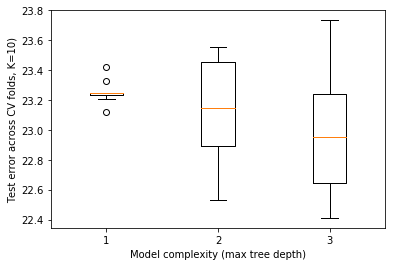

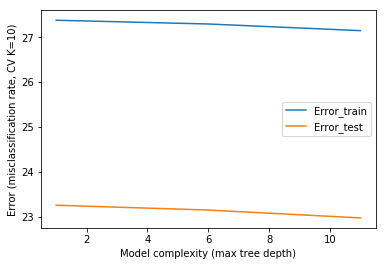

In [23]:
f = plt.figure()
plt.boxplot(NN_Error_test.T)
plt.xlabel('Model complexity (max tree depth)')
plt.ylabel('Test error across CV folds, K={0})'.format(10))

f = plt.figure()
plt.plot(Denseness, NN_Error_train.mean(1))
plt.plot(Denseness, NN_Error_test.mean(1))
plt.xlabel('Model complexity (max tree depth)')
plt.ylabel('Error (misclassification rate, CV K={0})'.format(10))
plt.legend(['Error_train','Error_test'])
    
plt.show()

In [ ]:
"""
f = plt.figure()
plt.plot(Denseness, NN_Error_train)
plt.plot(Denseness, NN_Error_test)
plt.xlabel('Model complexity (t-value')
plt.ylabel('Error (misclassification rate)'.format(1))
plt.legend(['Error_train','Error_test'])
    
plt.show()
""";

In [27]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

start = datetime.now()

model = Sequential()
model.add(LSTM(45, input_shape=(None,1), return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'linear'))
model.compile(loss='mean_absolute_error', optimizer='adam',metrics=['accuracy'])
model.fit(x_train, y_train, epochs=500, batch_size=10, verbose=0,validation_data=(x_test, y_test))
y_pred = model.predict(x_test)

print('Training and prediction done in {}'.format(datetime.now()-start))

Training and prediction done in 0:00:04.558185


In [16]:
y_pred

array([[[  3.48055959e-02],
        [ -1.01487398e+00],
        [  9.88503075e+00],
        [  4.17640800e+01],
        [  4.59047585e+01],
        [  3.95574303e+01],
        [  4.33518753e+01],
        [  1.89251270e+01],
        [  3.02874966e+01],
        [  4.69224930e+00],
        [  4.37746048e+00],
        [  4.20557594e+01]]], dtype=float32)

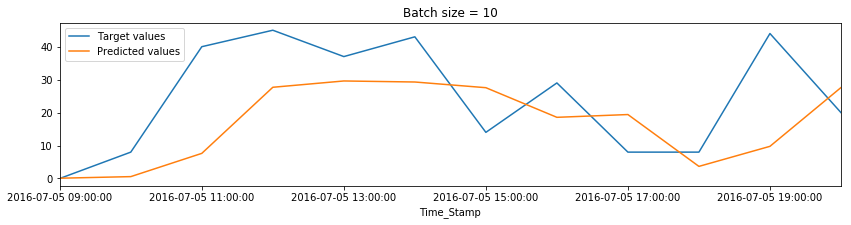

In [28]:
obj = pd.DataFrame(data['Jul16'].iloc[1:])
obj['pred'] = y_pred.reshape(12,1)
obj.plot(figsize=(14,3))
plt.legend(['Target values','Predicted values'])
plt.title('Batch size = 10')
plt.show()

In [72]:
obj

,Full%,pred
Time_Stamp,,
2016-07-05 09:00:00,0.0,0.051292
2016-07-05 10:00:00,8.0,-0.685117
2016-07-05 11:00:00,40.0,7.522802
2016-07-05 12:00:00,45.0,43.595360
2016-07-05 13:00:00,37.0,46.861935
2016-07-05 14:00:00,43.0,40.708691
2016-07-05 15:00:00,14.0,44.836090
2016-07-05 16:00:00,29.0,20.694576
2016-07-05 17:00:00,8.0,39.144894


In [ ]:
pandas.concat()